# Evaluating the Inverse of Analyzer Matrix Using Linear Regression
Solving the problem: S = A*I . Evaluate Ainv using sklearn's Linear Regression object which uses least suqares approximation. A is what is calculated by a least squares fit. Single $\mathbf{A}$ for each cam based on average intensity over a central image patch

Input is images for all the 3 cameras taken with different angles of the source polarizer

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import os
from os.path import dirname, join as pjoin
import scipy.io as sio
from collections import defaultdict
import os.path

In [24]:
def readRawImg(cam):
    """
    Function to read all the rescaled image files for cam (1, 2, or 3)
        args: cam: int: which camera id
        return matrix of all the images for a given camera and the image shape
    """
    
    # simple version for working with CWD to print number of files
    numFiles = 36
    #len([name for name in \
                    #os.listdir('cam_'+ str(cam) + '_Analyzer_Matrix')])
    
    for i in range(numFiles):
        image_file = 'cam_'+ str(cam) + '/Img_'+ str(i+1) # matlab saves images indexed from 1 to numFiles (inclusive)
        data_dir = pjoin('/Downloads/polar_cam/', 'cam_'+ str(cam)+ '_Analyzer_Matrix/')
        mat_fname = pjoin(data_dir, 'Cam_'+ str(cam)+ '_Image'+ str(i+1)+'RadioGeoCorrect.mat')
        img = sio.loadmat(mat_fname)['correct_img'] #plt.imread(image_file)
        if i ==0: 
            allImg = np.zeros((img.shape[0], img.shape[1], numFiles))
            fig, ax = plt.subplots()
            ax.imshow(img)
            ax.set_title('Camera {}'.format(str(cam)))
            plt.show()
        allImg[:,:,i] = img
    
    return allImg

In [18]:
def rescaleImg(images, factor):
    """
    Function to rescale all images for values between 0-1
        args: images: matrix of all images
    """
    return images/factor

In [19]:
def img2SrcPolarizerAngle():
    """
    Function that describes and returns the source polarizer to image sequence mapping
    Values are Hard-coded in this func
    Angles are in degrees
        return: ordered list with polar angles corresponding to images 
    """
    # there are as many angles as there are numFiles
    lst = np.array(np.arange(0,180, 5)) # to be tweaked based on how you took lab data
    print("angles are : ", lst)
    return lst

In [20]:
def getY(angles):
    """
    Create the inputs X: Each row of returned X is the intensity measured by camera 1, camera 2, and camera 2 resp.
        return: X
    """
    y = np.zeros((len(angles),3))
    y[:,0] = np.ones((len(angles))) 
    y[:,1] = np.cos(2*angles*np.pi/180).reshape((len(angles), )) #
    y[:,2] = np.sin(2*angles*np.pi/180).reshape((len(angles), )) #
    return y

In [21]:
def getX(angles, rstart, rend, cstart, cend, imgs):
    """
    Function to return the y for the regression fit. Here this is the theoretically known Stokes Vector component
        return : y
    """
    #len(angles)==numFiles
    X = np.zeros((3,len(angles)))
    X[0,:] = np.mean(imgs[1][rstart:rend, cstart:cend,:], axis=(0,1))
    X[1,:] = np.mean(imgs[2][rstart:rend, cstart:cend,:], axis=(0,1))
    X[2,:] = np.mean(imgs[3][rstart:rend, cstart:cend,:], axis=(0,1))
    return X.T

In [22]:
def getRegCoeffs(rstart, rend, cstrat, cend, imgs, angles):
    """
    Function to evaluate the regression coefficients of Ainv for the regression S = Ainv*I 
        args: 
            prow, pcol: row and col location of pixel for which regression happens
            imgs: dictionary of images from all 3 cameras
            cam: which camera are you calculating the regression for
            angles: the angles on the source polarizer sheet corresponding to which the images were taken
        return : regression coeffs
    """
    X = getX(angles, rstart, rend, cstart, cend, imgs)
    y = getY(angles)
    print("X.shape is  = ", X.shape)
    print("y.shape is  = ", y.shape)
#     print(X)
#     print(y)
    reg = LinearRegression(fit_intercept= False).fit(X, y)
    print("Coefficient of determination R^2 : ",reg.score(X, y))
    coeffs = reg.coef_
    print("Coefficients are : ", coeffs)
#     print("prediction : ",reg.predict(np.array([1, 0.5, 0.5]).reshape(-1, 1)))
    
    return coeffs

## Read Images

In [25]:
factor = 1
temp = readRawImg(2)
holder1 = np.zeros((temp.shape[0], temp.shape[1]))
print(holder1.shape)
imgs = dict([(1,holder1), (2,holder1), (3,holder1)])
imgs[1] = rescaleImg(temp, factor)
imgs[2] = rescaleImg(readRawImg(1), factor)
imgs[3] = rescaleImg(readRawImg(3), factor)

FileNotFoundError: [Errno 2] No such file or directory: '/Downloads/polar_cam/cam_2_Analyzer_Matrix/Cam_2_Image1RadioGeoCorrect.mat'

## Calculate angles

In [213]:
angles = img2SrcPolarizerAngle()

angles are :  [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175]


## Evaluate & Validate the Coefficients of regression
 (Single $\mathbf{A}$ for each cam based on average intensity over a central image patch)

**Note that the Analyzer matrix calculation is nearly constant for all pixels over the 3 images. So you can just average all pixel intensities or take a central well illuminated patch. Basically this averaging technique as implemented in this code allays the need for a pixel-wise Analyzer matrix**

To verify above, I tweaked the averaging patch size and location by varying the patch's edge locations. The $r^2$ is very high in all cases (even for a single pixeled size patch

In [259]:
cstart = 0#200
cend = holder1.shape[0]#800
rstart = 0#670
rend = holder1.shape[0]#1001#

# Evaluate the Analyzer matrix
A = getRegCoeffs(rstart, rend, cstart, cend, imgs, angles)
# Ainv = np.linalg.inv(coeffs)

# Validation
S0_theory = np.ones(angles.shape)
S1_theory = np.cos(2*angles*np.pi/180)
S2_theory = np.sin(2*angles*np.pi/180)

I_measured = getX(angles, rstart, rend, cstart, cend, imgs)
S_calc = A @ I_measured.T

X.shape is  =  (36, 3)
y.shape is  =  (36, 3)
Coefficient of determination R^2 :  0.9965532252527398
Coefficients are :  [[-0.05162506  0.058769    0.00664842]
 [ 0.11618334 -0.12257474  0.00109937]
 [-0.07462646  0.07092113  0.00690565]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


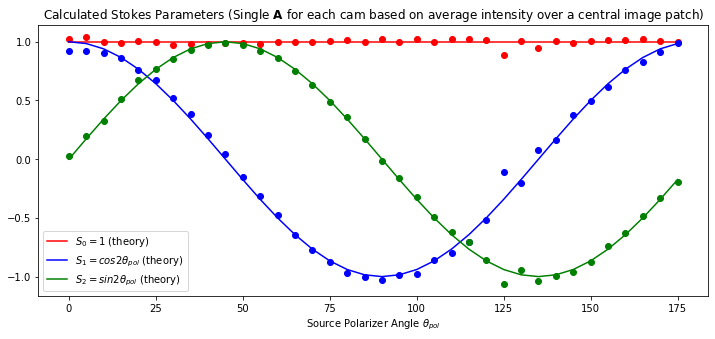

In [261]:
plt.figure(figsize = (12,5))
plt.plot(angles, S0_theory, 'r-', label = '$S_0 = 1$ (theory)')
plt.plot(angles, S_calc[0,:], 'ro')
plt.plot(angles, S1_theory, 'b-', label = '$S_1 = cos 2\\theta_{pol}$ (theory)')
plt.plot(angles, S_calc[1,:], 'bo')
plt.plot(angles, S2_theory, 'g-', label = '$S_2 = sin 2\\theta_{pol}$ (theory)')
plt.plot(angles, S_calc[2,:], 'go')
plt.legend()
plt.xlabel('Source Polarizer Angle $\\theta_{pol}$')
plt.title('Calculated Stokes Parameters (Single $\mathbf{A}$ for each cam based on average intensity over a central image patch)')
plt.show()